In [2]:
!pip install rpy2
%load_ext rpy2.ipython

In [3]:
%%R
install.packages("FNN")
install.packages("corrplot")
install.packages("tree")
install.packages("caret")
install.packages("gridExtra")
install.packages("tm")
install.packages("kernlab")
install.packages("e1071")
install.packages("Metrics")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("psych")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/FNN_1.1.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 78492 bytes (76 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to c

In [4]:
%%R
library(tidyverse) #most datascience related libraries
library(FNN) #knn regression
library(corrplot) # correlation plot
library(tree) # Decision Tree
library(caret) #train control
options(warn=-1) # filter warnings
library(gridExtra)
library(kernlab)
library(e1071) # mvc
library(Metrics) # loss function: mse, mae
library(tm) # preprossecing
library(ggplot2)
library(dplyr)
library(psych)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: corrplot 0.89 loaded

R[write to console]: Registered S3 method overwritten by 'tree':
  method     from
  print.tree cli 

R[write to console]: Loading required package: lattice

R[write to console]: 
Attaching package: ‘caret’


R[write to console]: The following object is masked from ‘package:purrr’:

    lift


R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine


R[write to console]: 
Attaching package: ‘kernlab’


R[write to conso

In [6]:
%%R
#Read csv
Vgsales <- read.csv("sample_data/Video_Games.csv",sep=",",na.strings=c(""," ","NA","N/A"))
head(Vgsales)

                      Name Platform Year_of_Release        Genre Publisher
1               Wii Sports      Wii            2006       Sports  Nintendo
2        Super Mario Bros.      NES            1985     Platform  Nintendo
3           Mario Kart Wii      Wii            2008       Racing  Nintendo
4        Wii Sports Resort      Wii            2009       Sports  Nintendo
5 Pokemon Red/Pokemon Blue       GB            1996 Role-Playing  Nintendo
6                   Tetris       GB            1989       Puzzle  Nintendo
  NA_Sales EU_Sales JP_Sales Other_Sales Global_Sales Critic_Score Critic_Count
1    41.36    28.96     3.77        8.45        82.53           76           51
2    29.08     3.58     6.81        0.77        40.24           NA           NA
3    15.68    12.76     3.79        3.29        35.52           82           73
4    15.61    10.93     3.28        2.95        32.77           80           73
5    11.27     8.89    10.22        1.00        31.37           NA         

In [7]:
%%R
na_count <-sapply(Vgsales, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count

                na_count
Name                   2
Platform               0
Year_of_Release      269
Genre                  2
Publisher             54
NA_Sales               0
EU_Sales               0
JP_Sales               0
Other_Sales            0
Global_Sales           0
Critic_Score        8582
Critic_Count        8582
User_Score          6704
User_Count          9129
Developer           6623
Rating              6769


In [8]:
%%R
#drop all NA values
Vgsales <- na.omit(Vgsales)
str(Vgsales)

'data.frame':	6825 obs. of  16 variables:
 $ Name           : chr  "Wii Sports" "Mario Kart Wii" "Wii Sports Resort" "New Super Mario Bros." ...
 $ Platform       : chr  "Wii" "Wii" "Wii" "DS" ...
 $ Year_of_Release: int  2006 2008 2009 2006 2006 2009 2005 2007 2010 2009 ...
 $ Genre          : chr  "Sports" "Racing" "Sports" "Platform" ...
 $ Publisher      : chr  "Nintendo" "Nintendo" "Nintendo" "Nintendo" ...
 $ NA_Sales       : num  41.4 15.7 15.6 11.3 14 ...
 $ EU_Sales       : num  28.96 12.76 10.93 9.14 9.18 ...
 $ JP_Sales       : num  3.77 3.79 3.28 6.5 2.93 4.7 4.13 3.6 0.24 2.53 ...
 $ Other_Sales    : num  8.45 3.29 2.95 2.88 2.84 2.24 1.9 2.15 1.69 1.77 ...
 $ Global_Sales   : num  82.5 35.5 32.8 29.8 28.9 ...
 $ Critic_Score   : int  76 82 80 89 58 87 91 80 61 80 ...
 $ Critic_Count   : int  51 73 73 65 41 80 64 63 45 33 ...
 $ User_Score     : chr  "8" "8.3" "8" "8.5" ...
 $ User_Count     : int  322 709 192 431 129 594 464 146 106 52 ...
 $ Developer      : chr  "Ninten

In [9]:
%%R
corpus <- VCorpus(VectorSource(Vgsales$Name))
#Converting to lowercase
corpus <- tm_map(corpus, content_transformer(tolower))

#Removing stop words
corpus <- tm_map(corpus, content_transformer(removeWords), stopwords('english'))

In [10]:
%%R
for(i in 1:length(Vgsales$Name)) {
  # i-th element of `u1` squared into `i`-th position of `usq`
  Vgsales$Name[[i]] <- strwrap(corpus[[i]])
}
head(Vgsales)

                       Name Platform Year_of_Release    Genre Publisher
1                wii sports      Wii            2006   Sports  Nintendo
3            mario kart wii      Wii            2008   Racing  Nintendo
4         wii sports resort      Wii            2009   Sports  Nintendo
7     new super mario bros.       DS            2006 Platform  Nintendo
8                  wii play      Wii            2006     Misc  Nintendo
9 new super mario bros. wii      Wii            2009 Platform  Nintendo
  NA_Sales EU_Sales JP_Sales Other_Sales Global_Sales Critic_Score Critic_Count
1    41.36    28.96     3.77        8.45        82.53           76           51
3    15.68    12.76     3.79        3.29        35.52           82           73
4    15.61    10.93     3.28        2.95        32.77           80           73
7    11.28     9.14     6.50        2.88        29.80           89           65
8    13.96     9.18     2.93        2.84        28.92           58           41
9    14.44     6

In [11]:
%%R
#drop all sales except global
Vgsales_df <- cbind(Vgsales[,-c(6:10)],Vgsales$Global_Sales)
Vgsales_df$Year_of_Release <- 2016 - Vgsales_df$Year_of_Release
names(Vgsales_df)[3] <- "Game_Age"
names(Vgsales_df)[12] <- "Global_Sales"
str(Vgsales_df)


'data.frame':	6825 obs. of  12 variables:
 $ Name        : chr  "wii sports" "mario kart wii" "wii sports resort" "new super mario bros." ...
 $ Platform    : chr  "Wii" "Wii" "Wii" "DS" ...
 $ Game_Age    : num  10 8 7 10 10 7 11 9 6 7 ...
 $ Genre       : chr  "Sports" "Racing" "Sports" "Platform" ...
 $ Publisher   : chr  "Nintendo" "Nintendo" "Nintendo" "Nintendo" ...
 $ Critic_Score: int  76 82 80 89 58 87 91 80 61 80 ...
 $ Critic_Count: int  51 73 73 65 41 80 64 63 45 33 ...
 $ User_Score  : chr  "8" "8.3" "8" "8.5" ...
 $ User_Count  : int  322 709 192 431 129 594 464 146 106 52 ...
 $ Developer   : chr  "Nintendo" "Nintendo" "Nintendo" "Nintendo" ...
 $ Rating      : chr  "E" "E" "E" "E" ...
 $ Global_Sales: num  82.5 35.5 32.8 29.8 28.9 ...


# **Visualizations of the data and analysis**

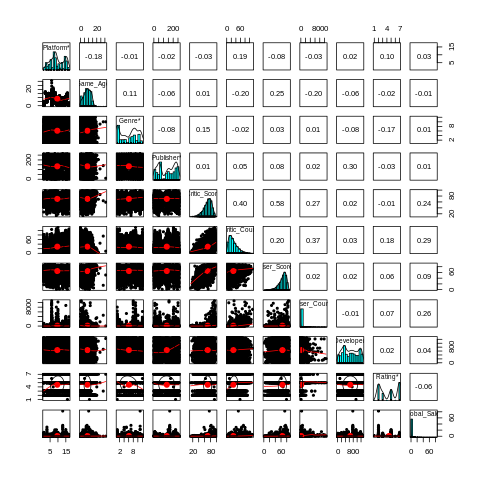

In [12]:
%%R
pairs.panels(Vgsales_df[-1])

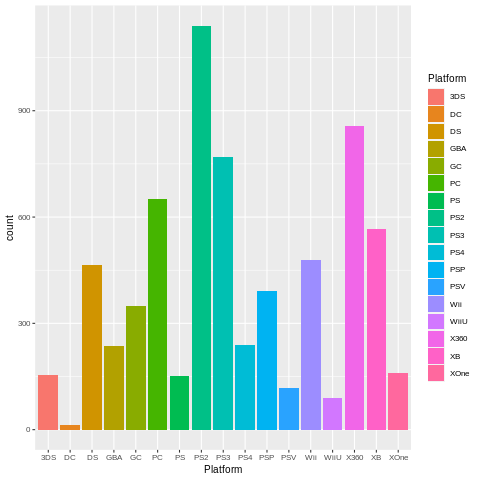

In [13]:
%%R
#creating a function to control figure size
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
count_platform <- function (Vgsales_df){
  fig(20,20)
  Platform_bar <- ggplot(Vgsales_df, aes(x=Platform,fill =Platform)) + geom_bar() + theme(text = element_text(size=10))  
  Platform_bar
}
count_platform (Vgsales_df)

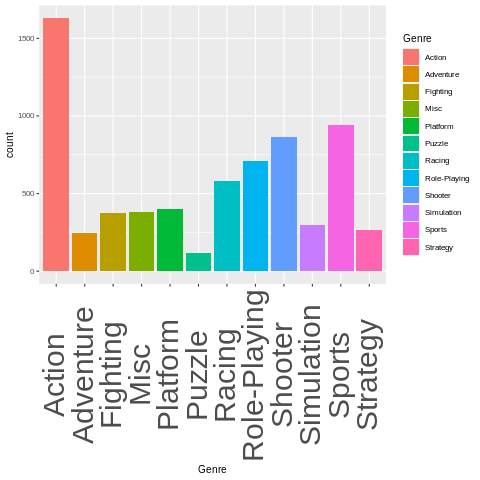

In [14]:
%%R
count_genre<- function(Vgsales_df){
  fig(15,15)
  Platform_bar <- ggplot(Vgsales_df, aes(x=Genre,fill =Genre)) + geom_bar() + theme(text = element_text(size=10),axis.text.x=element_text(angle = 90,vjust = 0.4,size=30))  
  Platform_bar
}
count_genre(Vgsales_df)

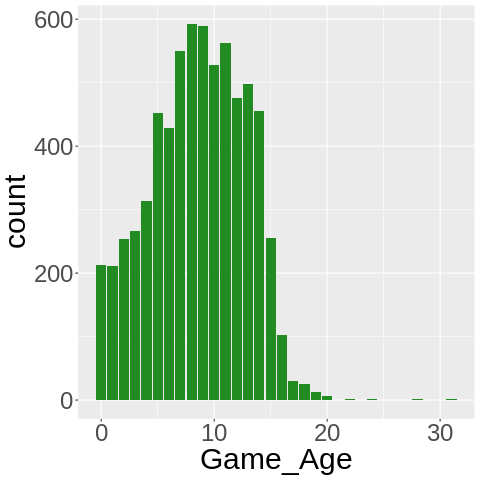

In [15]:
%%R
count_game_age <- function(Vgsales_df){
  fig(15,8)
  Age_bar <- ggplot(Vgsales_df, aes(x=Game_Age)) + geom_bar(fill = "forestgreen") + theme(text = element_text(size=30))  
  Age_bar
}
count_game_age(Vgsales_df)

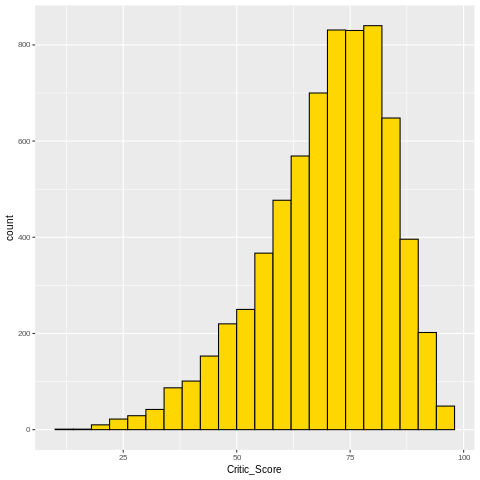

In [16]:
%%R
critic <- function(Vgsales_df,name_x, collor){
  fig(12, 12)
  Critic_hist <- ggplot(Vgsales_df,name_x)
  Critic_hist + geom_histogram(binwidth = 4, color = "black",fill = collor) + theme(text = element_text(size=10))
}
critic(Vgsales_df, aes(Critic_Score), "gold")

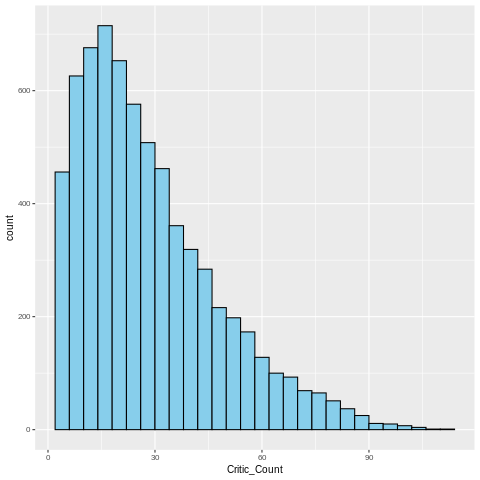

In [17]:
%%R
critic(Vgsales_df, aes(Critic_Count),  "skyblue")

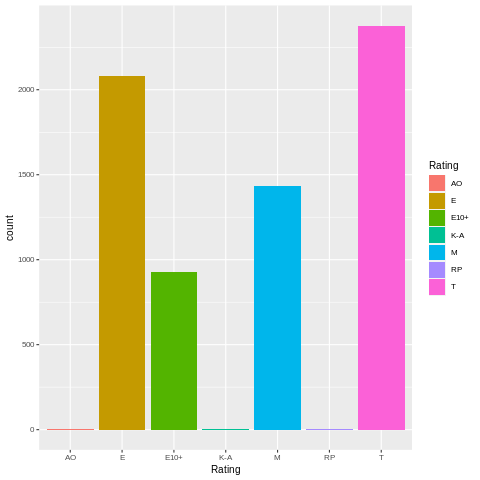

In [18]:
%%R
count_rating <- function(Vgsales_df){
  fig(15,15)
  Rating_bar <- ggplot(Vgsales_df, aes(x=Rating,fill =Rating)) + geom_bar() + theme(text = element_text(size=10))  
  Rating_bar
}
count_rating(Vgsales_df)

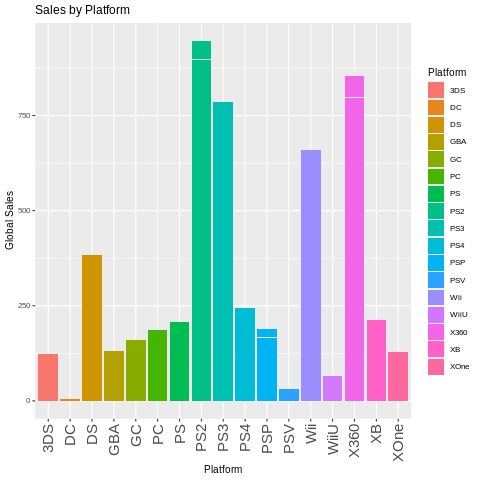

In [19]:
%%R
sales_by_platform <-function(Vgsales_df){
  fig(20,20)
  sales_by_platform <- ggplot(Vgsales_df, aes(Platform,Global_Sales,fill =Platform))
  sales_by_platform +geom_bar(stat = "identity") + 
  theme(text = element_text(size=10),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=15))+labs(x="Platform",y="Global Sales",title="Sales by Platform")
}
sales_by_platform(Vgsales_df)

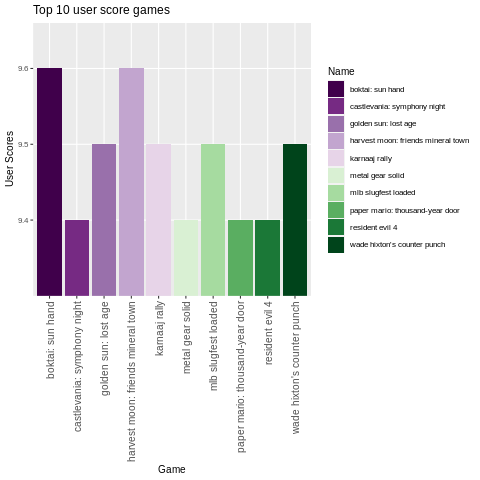

In [20]:
%%R
top_10_user_scores<- function (Vgsales_df, name_top_10,x_name,y_name,title_name,palette_name){
  fig(10,10)
  Vgsales_df %>% select(Name,User_Score) %>% arrange(desc(User_Score))%>% head(10)%>%
  ggplot(aes(x=Name,y=User_Score,fill=Name))+geom_bar(stat="identity")+
  theme(text = element_text(size=10),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=10))+labs(x=x_name,y=y_name,title=title_name)+scale_fill_brewer(palette=palette_name)
}
top_10_user_scores(Vgsales_df,User_Score,"Game","User Scores","Top 10 user score games","PRGn")

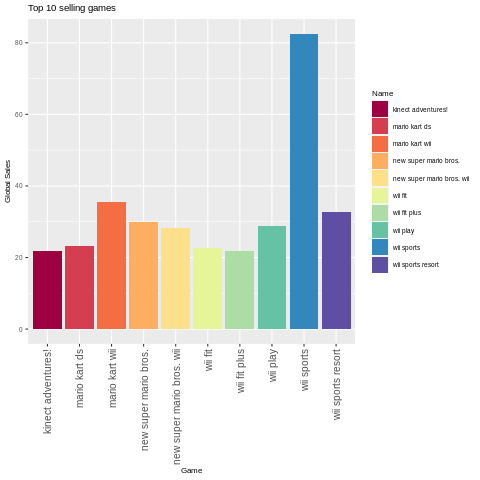

In [21]:
%%R
top_10_global_sales<- function (Vgsales_df, name_top_10,x_name,y_name,title_name,palette_name){
  fig(10,10)
  Vgsales_df %>% select(Name,Global_Sales) %>% arrange(desc(Global_Sales))%>% head(10)%>%
  ggplot(aes(x=Name,y=Global_Sales,fill=Name))+geom_bar(stat="identity")+
  theme(text = element_text(size=8),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=10))+labs(x=x_name,y=y_name,title=title_name)+scale_fill_brewer(palette=palette_name)
}
top_10_global_sales(Vgsales_df,Global_Sales,"Game","Global Sales","Top 10 selling games","Spectral")

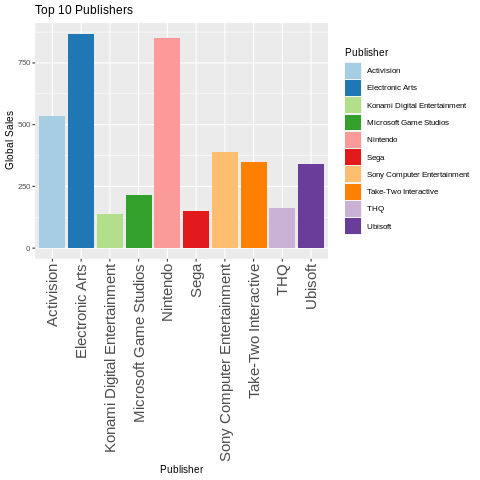

In [22]:
%%R
top_10_publisher<- function(Vgsales_df){
  Vgsales_df %>% select(Publisher,Global_Sales)%>%group_by(Publisher)%>%
  summarise(Total_sales=sum(Global_Sales))%>%arrange(desc(Total_sales))%>% head(10)%>%
  ggplot(aes(x=Publisher,y=Total_sales,fill=Publisher))+geom_bar(stat="identity")+
  theme(text = element_text(size=10),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=15))+labs(x="Publisher",y="Global Sales",title="Top 10 Publishers")+scale_fill_brewer(palette="Paired")
}
top_10_publisher(Vgsales_df)

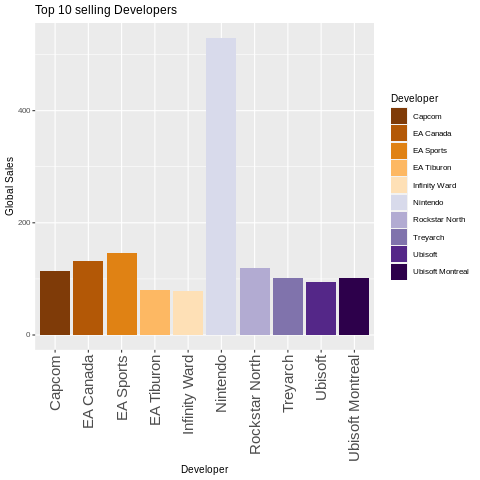

In [23]:
%%R
top_10_global_sales <- function(Vgsales_df){
  Vgsales_df %>% select(Developer,Global_Sales)%>%group_by(Developer)%>%
  summarise(Total_sales=sum(Global_Sales))%>%arrange(desc(Total_sales))%>% head(10)%>%
  ggplot(aes(x=Developer,y=Total_sales,fill=Developer))+geom_bar(stat="identity")+
  theme(text = element_text(size=10),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=15))+labs(x="Developer",y="Global Sales",title="Top 10 selling Developers")+scale_fill_brewer(palette="PuOr")
}
top_10_global_sales(Vgsales_df)

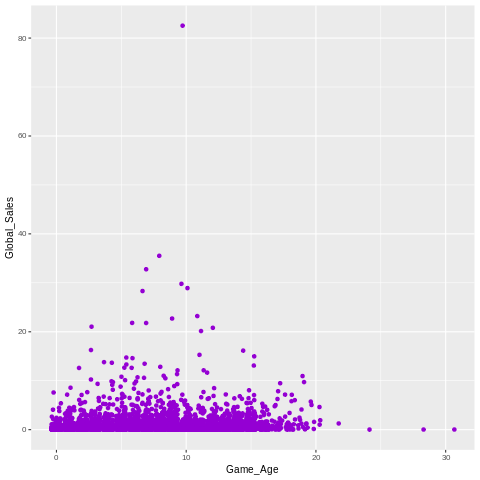

In [24]:
%%R
global_sales<-function(Vgsales_df,aes_,collor_name){
  Gs <- ggplot(Vgsales_df, aes_)
  Gs + geom_jitter(color = collor_name) + theme(text = element_text(size = 10))
}
global_sales(Vgsales_df,aes(Game_Age,Global_Sales),"darkviolet")

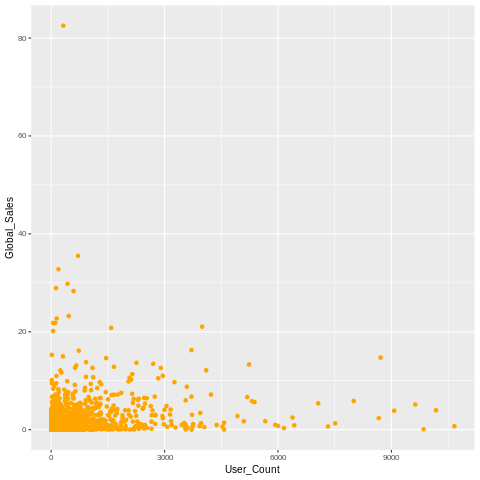

In [25]:
%%R
global_sales(Vgsales_df,aes(User_Count,Global_Sales),"orange")

## Statistical Models For Regression

In [26]:
%%R
#name column is an id column we can remove for good (only used for games Top ten sales)
Vgsales_df <- Vgsales_df[,-1]
knn.df <- Vgsales_df
for (i in 1:dim(knn.df)[2])
{
    knn.df[,i] <- as.numeric(knn.df[,i])
}
knn.df1 <- sapply(knn.df[,1:(dim(knn.df)[2]-1)],scale)
knn.df1 <- as.data.frame(knn.df1)
knn.df <- cbind(knn.df1,knn.df$Global_Sales)
names(knn.df)[11] = "Global_Sales"
knn.df = subset(knn.df, select = -c(Platform,Genre,Publisher,Developer,Rating) )
head(knn.df)

    Game_Age Critic_Score Critic_Count User_Score  User_Count Global_Sales
1  0.3411760    0.4130138    1.1479752  0.5655602  0.25071587        82.53
2 -0.1337426    0.8456467    2.2923682  0.7739019  0.90951941        35.52
3 -0.3712020    0.7014357    2.2923682  0.5655602  0.02941235        32.77
4  0.3411760    1.3503850    1.8762253  0.9127964  0.43627035        29.80
5  0.3411760   -0.8848847    0.6277965 -0.4067015 -0.07783473        28.92
6 -0.3712020    1.2061740    2.6564932  0.8433492  0.71375091        28.32


In [27]:
%%R
set.seed(5)
train.size <- floor(0.7*nrow(knn.df))
train.index <- sample(1:nrow(knn.df),train.size, replace = F)
train.set <- knn.df[train.index,]
test.set <- knn.df[-train.index,]
train.x <- train.set[,-6]
train.y <- train.set[,6]
test.x <- test.set[,-6]
test.y <- test.set[,6]

In [28]:
%%R
pred_003 <- FNN::knn.reg(train = train.x, test = test.x, y = train.y, k = 3)
diff3 = test.y-pred_003$pred
test_mse = mean(diff3^2)
test_mse

[1] 3.758232


In [29]:
%%R
knn.df1 <- knn.df
for (i in 1:ncol(knn.df1))
{
  print(names(knn.df1)[i]) 
  print(summary(lm(knn.df1$Global_Sales~knn.df1[,i],knn.df1)))
}

[1] "Game_Age"

Call:
lm(formula = knn.df1$Global_Sales ~ knn.df1[, i], data = knn.df1)

Residuals:
   Min     1Q Median     3Q    Max 
-0.794 -0.664 -0.485 -0.023 81.757 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.77759    0.02377   32.72   <2e-16 ***
knn.df1[, i] -0.01308    0.02377   -0.55    0.582    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.964 on 6823 degrees of freedom
Multiple R-squared:  4.437e-05,	Adjusted R-squared:  -0.0001022 
F-statistic: 0.3027 on 1 and 6823 DF,  p-value: 0.5822

[1] "Critic_Score"

Call:
lm(formula = knn.df1$Global_Sales ~ knn.df1[, i], data = knn.df1)

Residuals:
   Min     1Q Median     3Q    Max 
-1.536 -0.680 -0.324  0.162 81.560 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.77759    0.02309   33.68   <2e-16 ***
knn.df1[, i]  0.46643    0.02309   20.20   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.0

In [30]:
%%R
k = seq(1,51,2)
i=1 
Mse=1                     

for (i in k)
{
  knn.mod <-  FNN::knn.reg(train = train.x, test = test.x, y = train.y, k = i)  
  Mse[i] <-mean((test.y - knn.mod$pred)^2)
  k=i  
  cat(k,'=',round(Mse[i],2),'\n')        
}

1 = 4.3 
3 = 3.76 
5 = 3.44 
7 = 3.3 
9 = 3.2 
11 = 3.14 
13 = 3.12 
15 = 3.13 
17 = 3.12 
19 = 3.11 
21 = 3.12 
23 = 3.13 
25 = 3.13 
27 = 3.13 
29 = 3.13 
31 = 3.13 
33 = 3.14 
35 = 3.14 
37 = 3.16 
39 = 3.16 
41 = 3.15 
43 = 3.16 
45 = 3.16 
47 = 3.17 
49 = 3.18 
51 = 3.18 


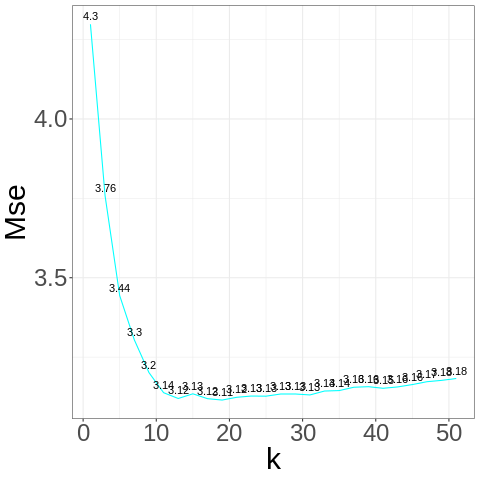

In [31]:
%%R
k = seq(1,51,2)
Mse <- na.omit(Mse)
Mseplot = data.frame(k,Mse)
ggplot(Mseplot,aes(x=k,y=Mse))+
  geom_line(col = "cyan")+
  expand_limits(y=Mse[0])+
  theme_bw() +
  geom_text(aes(label=round(Mse,2)),vjust = -0.5) +
  theme(text = element_text(size = 30))

# mininmum Mse is 3.12 which is higher, which means that for this model we remain with all our variables.

## cross validation


In [32]:
%%R
fitted_value<- 0
for(i in 1:nrow(knn.df))
{
    test.set<- knn.df[i,]
    train.set<- knn.df[-i,]
    train.x <- train.set[,-6]
    train.y <- train.set[,6]
    test.x <- test.set[,-6]
    test.y <- test.set[,6]
    model1<-FNN::knn.reg(train = train.x, test = test.x, y = train.y, k = 19) 
    #when you fit the model, use the newdata argument to predict on a new row
    #also, fitted_value needs the index [i], so the each loop doesn't overwrite the previous
    fitted_value[i] <- model1$pred
    
}
knn.mse <- round(mean((fitted_value-test.y)^2),2)
print(knn.mse)
knn.mae <- round(mean(abs(fitted_value-test.y)),2)
print(knn.mae)
# We have reached with leave one out and a k=19 an mse of 1.3 which is significantly lower than the first knn reg model 3.12.

[1] 1.3
[1] 0.75


## Linear Regression

In [33]:
%%R
#df copy
lr.df <- Vgsales_df
str(lr.df)

'data.frame':	6825 obs. of  11 variables:
 $ Platform    : chr  "Wii" "Wii" "Wii" "DS" ...
 $ Game_Age    : num  10 8 7 10 10 7 11 9 6 7 ...
 $ Genre       : chr  "Sports" "Racing" "Sports" "Platform" ...
 $ Publisher   : chr  "Nintendo" "Nintendo" "Nintendo" "Nintendo" ...
 $ Critic_Score: int  76 82 80 89 58 87 91 80 61 80 ...
 $ Critic_Count: int  51 73 73 65 41 80 64 63 45 33 ...
 $ User_Score  : chr  "8" "8.3" "8" "8.5" ...
 $ User_Count  : int  322 709 192 431 129 594 464 146 106 52 ...
 $ Developer   : chr  "Nintendo" "Nintendo" "Nintendo" "Nintendo" ...
 $ Rating      : chr  "E" "E" "E" "E" ...
 $ Global_Sales: num  82.5 35.5 32.8 29.8 28.9 ...


In [34]:
%%R
# train and test
set.seed(5)
train.size <- floor(0.7*nrow(lr.df))
train.index <- sample(1:nrow(lr.df),train.size, replace = F)
train.set <- lr.df[train.index,]
test.set <- lr.df[-train.index,]

In [35]:
%%R
# First Model-For this model a random decision of variables is decided
reg1 <- lm(Global_Sales ~., data = test.set)
predicted1 = predict(reg1, newdata = test.set)
Mse = mean((test.set$Global_Sales - predicted1)^2)
cat("Mse = ",Mse)

Mse =  1.813412

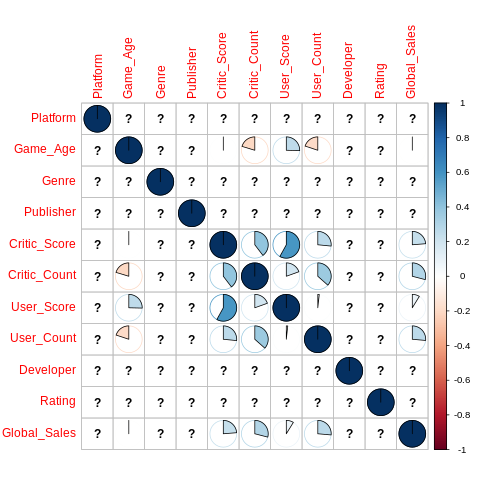

In [36]:
%%R
# Model improvement
lr.df1 <- lr.df 
lr.df1$Platform <- as.numeric(lr.df1$Platform)
lr.df1$Genre <- as.numeric(lr.df1$Genre)
lr.df1$Publisher <- as.numeric(lr.df1$Publisher)
lr.df1$User_Score <- as.numeric(lr.df1$User_Score)
lr.df1$Developer <- as.numeric(lr.df1$Developer)
lr.df1$Rating <- as.numeric(lr.df1$Rating)
Vgs.cor = cor(lr.df1)
corrplot(Vgs.cor,method = "pie")

In [37]:
%%R
reg2 <- lm(Global_Sales ~Critic_Score + Critic_Count + User_Count, data = train.set)
summary(reg2)


Call:
lm(formula = Global_Sales ~ Critic_Score + Critic_Count + User_Count, 
    data = train.set)

Residuals:
   Min     1Q Median     3Q    Max 
-6.106 -0.549 -0.237  0.163 81.209 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -9.721e-01  1.391e-01  -6.991 3.11e-12 ***
Critic_Score  1.666e-02  2.090e-03   7.970 1.97e-15 ***
Critic_Count  1.660e-02  1.576e-03  10.534  < 2e-16 ***
User_Count    5.627e-04  4.729e-05  11.898  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.841 on 4773 degrees of freedom
Multiple R-squared:  0.1189,	Adjusted R-squared:  0.1184 
F-statistic: 214.7 on 3 and 4773 DF,  p-value: < 2.2e-16



In [38]:
%%R
predicted2 = predict(reg2, newdata = test.set)
Mse = mean((test.set$Global_Sales - predicted2)^2)
cat("Mse = ",Mse)

Mse =  3.338974

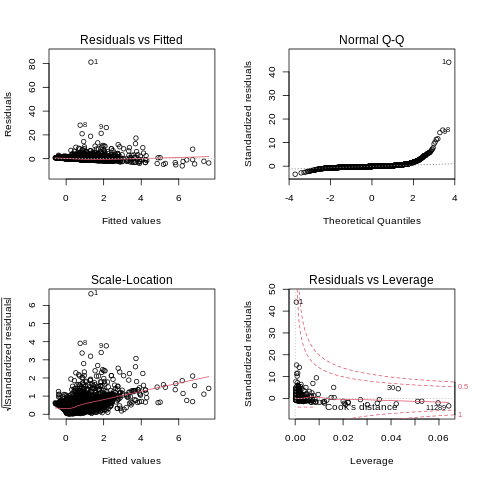

In [39]:
%%R
par(mfrow=c(2,2))
plot(reg2)

In [40]:
%%R
reg3 = lm(Global_Sales ~Platform + Game_Age + Genre + Critic_Score +Critic_Count + User_Count + Rating, data = train.set)
summary(reg3)


Call:
lm(formula = Global_Sales ~ Platform + Game_Age + Genre + Critic_Score + 
    Critic_Count + User_Count + Rating, data = train.set)

Residuals:
   Min     1Q Median     3Q    Max 
-6.954 -0.568 -0.170  0.252 79.983 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -6.236e-01  1.801e+00  -0.346  0.72913    
PlatformDC        -8.207e-01  6.416e-01  -1.279  0.20088    
PlatformDS        -9.849e-03  2.091e-01  -0.047  0.96243    
PlatformGBA       -4.905e-01  2.504e-01  -1.959  0.05019 .  
PlatformGC        -6.174e-01  2.366e-01  -2.609  0.00911 ** 
PlatformPC        -1.094e+00  2.020e-01  -5.416  6.4e-08 ***
PlatformPS         2.672e-01  2.915e-01   0.917  0.35931    
PlatformPS2       -2.325e-01  2.141e-01  -1.086  0.27761    
PlatformPS3       -9.919e-02  1.921e-01  -0.516  0.60570    
PlatformPS4       -2.599e-01  2.279e-01  -1.140  0.25431    
PlatformPSP       -3.472e-01  2.148e-01  -1.617  0.10598    
PlatformPSV       -4.349e-01  

In [41]:
%%R
predicted = predict(reg3, newdata = test.set)
Mse = mean((test.set$Global_Sales - predicted)^2)
cat("Mse = ",Mse)

Mse =  3.083167

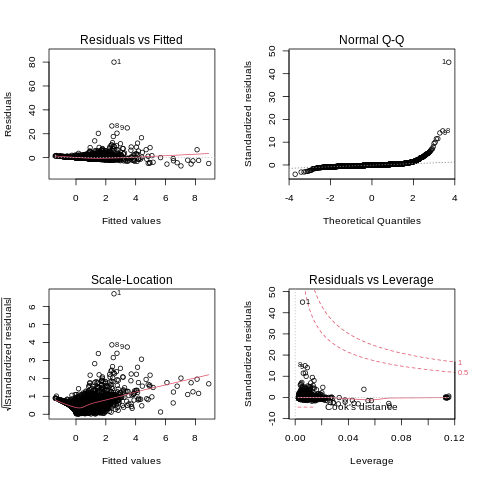

In [42]:
%%R
par(mfrow=c(2,2))
plot(reg3)

In [43]:
%%R
# Define training control
train.control <- trainControl(method = "cv", number = 3)

model <- train(Global_Sales ~., data = lr.df, method = "lm",
               trControl = train.control)
# Summarize the results
print(model)

Linear Regression 

6825 samples
  10 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 4549, 4550, 4551 
Resampling results:

  RMSE      Rsquared   MAE      
  1.658922  0.2989167  0.7909993

Tuning parameter 'intercept' was held constant at a value of TRUE


In [44]:
%%R
lr.mae <- 0.79
lr.mse <- 1.66

# svm

In [45]:
%%R
#df copy
svm.df <- Vgsales_df
model_svm <- svm(Global_Sales ~., data = test.set)
pred <- predict(model_svm, newdata = test.set)

In [46]:
%%R
# loss function
svm.mae <- mae(test.set$Global_Sales,pred)
svm.mse <- mse(test.set$Global_Sales,pred)

## Decision Tree

In [47]:
%%R
# because of model limits the X variables will consist of less variables, only high correlated (see correlation plot in linear regression model)
dt.df <- lr.df #data copy
set.seed(5)
tree.vgs=tree(Global_Sales~Critic_Score + Critic_Count + User_Count,dt.df,subset=train.index)
summary(tree.vgs)


Regression tree:
tree(formula = Global_Sales ~ Critic_Score + Critic_Count + User_Count, 
    data = dt.df, subset = train.index)
Number of terminal nodes:  8 
Residual mean deviance:  2.932 = 13980 / 4769 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-12.9600  -0.3578  -0.2189   0.0000   0.1122  69.5500 


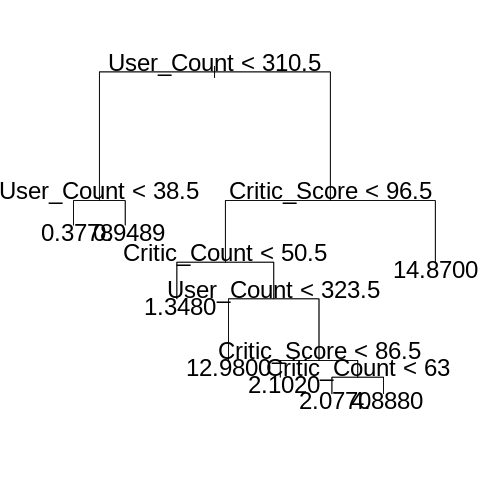

In [48]:
%%R
#Plotting Regression Tree

plot(tree.vgs)
text(tree.vgs,pretty=0, cex = 2)

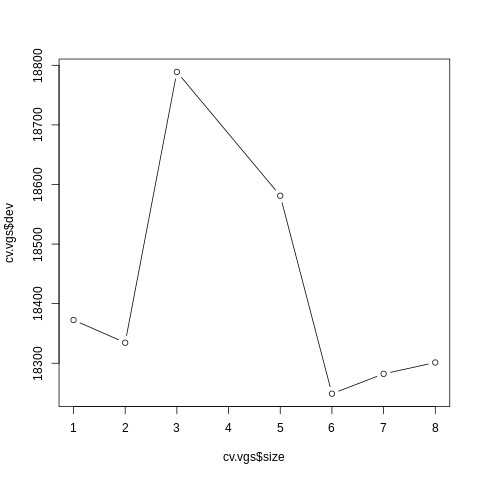

In [49]:
%%R
# Cross - Validation Analysis

cv.vgs=cv.tree(tree.vgs)
plot(cv.vgs$size,cv.vgs$dev,type='b')

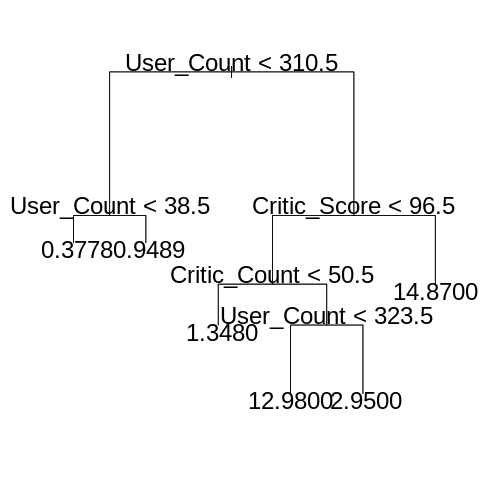

In [50]:
%%R
prune.vgs=prune.tree(tree.vgs,best=6)

plot(prune.vgs)
text(prune.vgs,pretty=0,cex = 2)

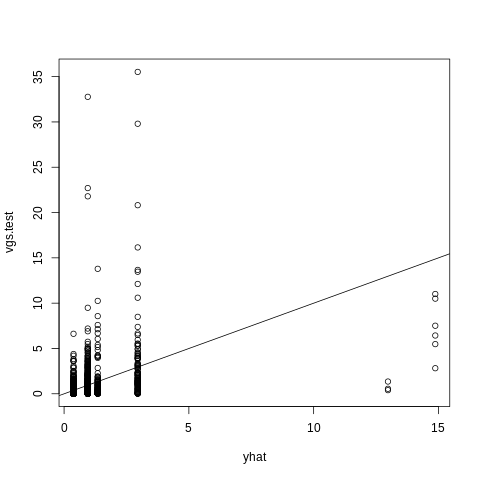

In [51]:
%%R
yhat=predict(prune.vgs,newdata=dt.df[-train.index,])
yhat2=predict(tree.vgs,newdata=dt.df[-train.index,])
vgs.test=dt.df[-train.index,"Global_Sales"]
plot(yhat,vgs.test)
abline(0,1)

In [52]:
%%R
t8 = mean((yhat2-vgs.test)^2)
t6 = mean((yhat-vgs.test)^2)
dt.mae <- mean(abs(yhat-vgs.test))
cat("full tree mse = ", t8,"\n")
cat("6 leaf tree mse = ", t6)
dt.mse <- t8

full tree mse =  3.579012 
6 leaf tree mse =  3.660188

## Conclusion

In [53]:
%%R
MAE <- round(c(knn.mae, lr.mae,dt.mae, svm.mae),2)
MSE <- round(c(knn.mse, lr.mse,dt.mse,svm.mse),2)
Models <- c("K - Nearest Neighbors", "Linear Regression", "Decision Tree","SVM")

Models <- data.frame(Models,MAE,MSE)
Models

                 Models  MAE  MSE
1 K - Nearest Neighbors 0.75 1.30
2     Linear Regression 0.79 1.66
3         Decision Tree 0.72 3.58
4                   SVM 0.57 3.51


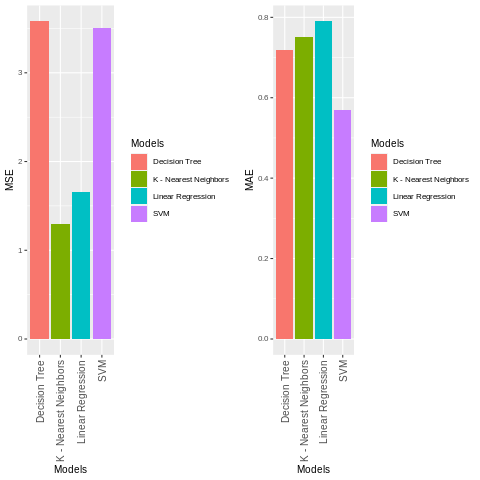

In [54]:
%%R
fig(20,8)
require(gridExtra)
plot1 <- ggplot(Models, aes(x=Models,y=MSE,fill=Models))+geom_bar(stat="identity")+ theme(text = element_text(size=10),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=10))
plot2 <- ggplot(Models, aes(x=Models,y=MAE,fill=Models))+geom_bar(stat="identity")+ theme(text = element_text(size=10),legend.position="right",axis.text.x=element_text(angle = 90,vjust = 0.5,hjust = 1,size=10))+expand_limits(y=0.6)
grid.arrange(plot1, plot2, ncol=2)